In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import datetime as dt
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import scipy.stats as sps

from statsmodels.stats.proportion import proportion_confint

In [ ]:
#import data
data = pd.read_csv('product_analytics_dataset.csv', sep = ';')

In [ ]:
data['hit_dttm'] = pd.to_datetime(data['hit_dttm'], format = "%d.%m.%Y %H:%M")

In [ ]:
data['date'] = data['hit_dttm'].dt.date
data


,hit_dttm,source,ab_test_version,device_type,visitor_id,visit_num,event_name,date
0,2021-01-01 00:12:00,source3,2041:control,Mobile,59112.0,5,pageview,2021-01-01
1,2021-01-01 00:14:00,source3,2041:test,Mobile,70394.0,1,pageview,2021-01-01
2,2021-01-01 00:22:00,source3,1547:control,Mobile,6802.0,1,pageview,2021-01-01
3,2021-01-01 00:56:00,source3,2041:control,Desktop,NaN,1,pageview,2021-01-01
4,2021-01-01 01:44:00,source3,2041:control,Mobile,63541.0,3,pageview,2021-01-01
...,...,...,...,...,...,...,...,...
99995,2021-01-14 23:38:00,source2,2454:control,Mobile,NaN,1,pageview,2021-01-14
99996,2021-01-14 23:40:00,source3,2459:control,Desktop,18797.0,4,pageview,2021-01-14
99997,2021-01-14 23:42:00,source3,2459:control,Mobile,44382.0,1,pageview,2021-01-14
99998,2021-01-14 23:46:00,source3,2459:test,Mobile,23312.0,1,pageview,2021-01-14


In [ ]:
np.unique(data['event_name'])

array(['formStep2', 'formStep3', 'formStep4', 'formSubmit', 'pageview'],
      dtype=object)

In [ ]:
#I made a separate dataset for the ab test №2459
clean_data_2459 = data.copy().query("ab_test_version in ('2459:control','2459:test')").drop_duplicates().dropna()

clean_data_2459['visitor_id'] = clean_data_2459['visitor_id'].astype('int')

In [ ]:
#some users are present in both the control and the test sample
set(clean_data_2459.query('ab_test_version == "2459:control"')['visitor_id'])\
& set(clean_data_2459.query('ab_test_version == "2459:test"')['visitor_id'])

{2888,
 2892,
 3745,
 5473,
 8043,
 9020,
 17272,
 19911,
 25692,
 27923,
 29650,
 29764,
 34946,
 35492,
 36734,
 43525,
 50215,
 51058,
 58169,
 58988,
 59834,
 62966,
 66804,
 71636,
 72921}

In [ ]:
#drop these users
clean_data_2459 = clean_data_2459[~clean_data_2459.visitor_id.isin(list(set(clean_data_2459.query('ab_test_version == "2459:control"')['visitor_id']) & set(clean_data_2459.query('ab_test_version == "2459:test"')['visitor_id'])))]

In [ ]:
temp1 = clean_data_2459.loc[(clean_data_2459['ab_test_version']=='2459:control') & (clean_data_2459['event_name']=='formSubmit')]\
.groupby(['visitor_id','visit_num']).agg({'event_name':'count'})
temp1 = temp1.rename(columns = {'event_name': 'formsubmit'})
temp1

,,formsubmit
visitor_id,visit_num,
65,6,1
96,1,1
273,2,1
283,12,1
286,1,1
...,...,...
74447,9,1
74820,1,1
74885,1,1


In [ ]:
temp2 = clean_data_2459.loc[(clean_data_2459['ab_test_version']=='2459:control')]\
.groupby(['visitor_id','visit_num']).agg({'event_name':'count'})
temp2 = temp2.rename(columns = {'event_name': 'pageview'})
temp2

,,pageview
visitor_id,visit_num,
2,13,1
3,2,1
7,2,1
15,1,1
16,2,1
...,...,...
75498,1,1
75501,1,1
75504,2,1


In [ ]:
first_time = clean_data_2459.loc[(clean_data_2459['ab_test_version']=='2459:control')].groupby(['visitor_id', 'visit_num']).agg({'hit_dttm' : min})
first_time = first_time.rename(columns = {'hit_dttm' : 'first_time'})
first_time

,,first_time
visitor_id,visit_num,
2,13,2021-01-14 09:33:00
3,2,2021-01-14 09:48:00
7,2,2021-01-12 03:47:00
15,1,2021-01-12 11:17:00
16,2,2021-01-11 17:42:00
...,...,...
75498,1,2021-01-13 20:46:00
75501,1,2021-01-12 08:40:00
75504,2,2021-01-11 19:24:00


In [ ]:
#creating dataset for control version
visits_cr_control = temp2.merge(temp1,how = 'left', left_index=True, right_index=True)
visits_cr_control.fillna(int(0),inplace = True)
visits_cr_control['pageview'] = 1
visits_cr_control.loc[visits_cr_control['formsubmit'] > 1, 'formsubmit'] = 1
visits_cr_control = visits_cr_control.merge(first_time, how = 'left', left_index=True, right_index=True)
visits_cr_control = visits_cr_control.sort_values('first_time')
visits_cr_control

,,pageview,formsubmit,first_time
visitor_id,visit_num,,,
40941,28,1,0.0,2021-01-11 10:20:00
40453,6,1,0.0,2021-01-11 10:20:00
11085,1,1,0.0,2021-01-11 10:20:00
5643,1,1,0.0,2021-01-11 10:20:00
26680,1,1,0.0,2021-01-11 10:20:00
...,...,...,...,...
71704,1,1,0.0,2021-01-14 23:24:00
17900,1,1,0.0,2021-01-14 23:26:00
22739,1,1,0.0,2021-01-14 23:33:00


In [ ]:
temp1 = clean_data_2459.loc[(clean_data_2459['ab_test_version']=='2459:test') & (clean_data_2459['event_name']=='formSubmit')]\
.groupby(['visitor_id','visit_num']).agg({'event_name':'count'})
temp1 = temp1.rename(columns = {'event_name': 'formsubmit'})
temp1

,,formsubmit
visitor_id,visit_num,
47,1,1
169,2,1
529,1,1
650,10,1
747,2,1
...,...,...
75278,1,1
75284,1,1
75295,7,1


In [ ]:
temp2 = clean_data_2459.loc[(clean_data_2459['ab_test_version']=='2459:test')]\
.groupby(['visitor_id','visit_num']).agg({'event_name':'count'})
temp2 = temp2.rename(columns = {'event_name': 'pageview'})
temp2

,,pageview
visitor_id,visit_num,
1,2,1
5,2,1
6,1,1
8,3,1
9,3,1
...,...,...
75495,2,1
75499,1,1
75500,1,1


In [ ]:
first_time = clean_data_2459.loc[(clean_data_2459['ab_test_version']=='2459:test')].groupby(['visitor_id', 'visit_num']).agg({'hit_dttm' : min})
first_time = first_time.rename(columns = {'hit_dttm' : 'first_time'})
first_time

,,first_time
visitor_id,visit_num,
1,2,2021-01-12 00:38:00
5,2,2021-01-12 01:07:00
6,1,2021-01-12 11:06:00
8,3,2021-01-13 13:57:00
9,3,2021-01-12 08:48:00
...,...,...
75495,2,2021-01-12 12:07:00
75499,1,2021-01-12 18:09:00
75500,1,2021-01-12 11:22:00


In [ ]:
#creating dataset for control version
visits_cr_test = temp2.merge(temp1,how = 'left', left_index=True, right_index=True)
visits_cr_test.fillna(int(0),inplace = True)
visits_cr_test['pageview'] = 1
visits_cr_test.loc[visits_cr_test['formsubmit'] > 1, 'formsubmit'] = 1
visits_cr_test = visits_cr_test.merge(first_time, how = 'left', left_index=True, right_index=True)
visits_cr_test = visits_cr_test.sort_values('first_time')
visits_cr_test

,,pageview,formsubmit,first_time
visitor_id,visit_num,,,
14286,3,1,0.0,2021-01-11 10:20:00
10989,15,1,0.0,2021-01-11 10:20:00
39963,2,1,0.0,2021-01-11 10:20:00
12675,9,1,0.0,2021-01-11 10:20:00
66317,2,1,0.0,2021-01-11 10:20:00
...,...,...,...,...
63424,1,1,1.0,2021-01-14 23:31:00
20818,1,1,0.0,2021-01-14 23:32:00
50468,2,1,0.0,2021-01-14 23:37:00


In [ ]:
#dataset for test version
# Y - amount of visits of user
# X - amount of submits of user
df_test = \
visits_cr_test.groupby('visitor_id').agg({'pageview':'sum'}).merge(visits_cr_test.groupby('visitor_id').agg({'formsubmit':'sum'}),\
                                                                   on = ['visitor_id'])
df_test = df_test.rename(columns= {'pageview':'Y','formsubmit':'X'})

#dataset for test version
df_control = \
visits_cr_control.groupby('visitor_id').agg({'pageview':'sum'}).merge(visits_cr_control.groupby('visitor_id').agg({'formsubmit':'sum'}),\
                                                                   on = ['visitor_id'])
df_control = df_control.rename(columns = {'pageview':'Y','formsubmit':'X'})
df_control

,Y,X
visitor_id,,
2,1,0.0
3,1,0.0
7,1,0.0
15,1,0.0
16,1,0.0
...,...,...
75496,1,0.0
75498,1,0.0
75501,1,0.0


In [ ]:
#delta method
def check_delta_method(a, b):
    """Проверка гипотезы с помощью дельта-метода.

    Возвращает p-value.
    """
    dict_ = {}
    for data, group_name in [(a, 'a',), (b, 'b',)]:
        n_user = len(data)
        array_x = np.array(data['X'])
        array_y = np.array(data['Y'])
        mean_x, mean_y = np.mean(array_x), np.mean(array_y)
        var_x, var_y = np.var(array_x), np.var(array_y)
        cov_xy = np.cov(array_x, array_y)[0, 1]
        # точечная оценка метрики
        pe_metric = np.sum(array_x) / np.sum(array_y)
        # оценка дисперсии метрики
        var_metric = (
            var_x / mean_y ** 2
            - 2 * (mean_x / mean_y ** 3) * cov_xy
            + (mean_x ** 2 / mean_y ** 4) * var_y
        ) / n_user
        dict_[f'pe_metric_{group_name}'] = pe_metric
        dict_[f'var_metric_{group_name}'] = var_metric
    var = dict_['var_metric_a'] + dict_['var_metric_b']
    delta = dict_['pe_metric_b'] - dict_['pe_metric_a']
    t = delta / np.sqrt(var)
    pvalue = 1 - stats.norm.cdf(t)
    return [pvalue,dict_]

In [ ]:
#sample size for t-test
def ttest_sample_size(control, mde, sig=0.05, power=0.8):
    control_var = np.var(control)
    test_var = control_var
    mde = np.mean(control)*mde
    z_power, z_sig = sps.norm.ppf([1-power, 1-sig])
    n = round((test_var+control_var)*((z_sig-z_power)**2)/(mde**2))
    return n

#t-test
def absolute_ttest(control, test):
    mean_control = np.mean(control)
    mean_test = np.mean(test)
    var_mean_control  = np.var(control) / len(control)
    var_mean_test  = np.var(test) / len(test)

    difference_mean = mean_test - mean_control
    difference_mean_var = var_mean_control + var_mean_test
    t_stat = difference_mean/np.sqrt(difference_mean_var)
    t_stat_distribution = sps.norm(loc=0, scale=1)
    pvalue = 1 - t_stat_distribution.cdf(t_stat)
    return [pvalue, t_stat]


In [ ]:
#creates transformations for linearization method
def linearization(a,b):
    alpha = np.sum(a['X'])/np.sum(a['Y'])
    control = a['X']-alpha*a['Y']
    test = b['X']-alpha*b['Y']
    return [control.values, test.values]


In [ ]:
#sample size for proportion z-test

def z_test_size(theta_c, theta_t, alpha = 0.05, beta = 0.2):
    # вычисляем квантили нормального распределения
    t_alpha = stats.norm.ppf(1 - alpha, loc=0, scale=1)
    t_beta = stats.norm.ppf(beta, loc=0, scale=1)
    # решаем уравнение относительно n
    n = t_alpha*np.sqrt(theta_t*(1 - theta_t))
    n -= t_beta*np.sqrt(theta_c*(1 - theta_c))
    n /= theta_c - theta_t
    return int(np.ceil(n*n))

In [ ]:
#z-test
def z_test(A,B):
  s1 = np.sum(A['X'])
  n1 = np.sum(A['Y'])
  s2 = np.sum(B['X'])
  n2 = np.sum(B['Y'])
  p1 = s1 / n1
  p2 = s2 / n2
  p = (s1 + s2) / (n1 + n2)
  z = (p2 - p1) / ((p * (1 - p) * ((1 / n1) + (1 / n2)))**0.5)
  p_value = 1-stats.norm.cdf(z)
  return p_value

In [ ]:
#bootstrap realization
def get_bootstrap(
    A,
    B,
    graph = False,
    boot_it = 1000,
    bootstrap_conf_level = 0.95
):
    boot_len = max([len(A), len(B)])
    boot_data = []
    for i in range(boot_it):
        samples_1 = A.sample(n = boot_len, replace = True)
        samples_2 = B.sample(n = boot_len, replace = True)


        boot_data.append(np.sum(samples_2['X'])/np.sum(samples_2['Y']) - np.sum(samples_1['X'])/np.sum(samples_1['Y']))
    pd_boot_data = pd.DataFrame(boot_data)

    quant = pd_boot_data.quantile([1-bootstrap_conf_level])

    p_value = stats.norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )

    if(graph is True):
        _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
        for bar in bars:
            if bar.get_x() <= quant.iloc[0][0]:
                bar.set_facecolor('red')
            else:
                bar.set_facecolor('grey')
                bar.set_edgecolor('black')

        plt.style.use('ggplot')
        plt.vlines(quant,ymin = 0,ymax = 50,linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.rcParams['figure.figsize'] = [14, 8]
        plt.show()
    return p_value

In [ ]:
#realization of method from "Dealing With Ratio Metrics in A/B Testing at the Presence of Intra-User Correlation and Segments" article
def intra_user_correlation_aware_weights(clicks_0, clicks_1, views_0, views_1):
    """
    :param clicks_0: np.array размера (n_experiments, n_users), clicks of control group
    :param views_0: np.array размера (n_experiments, n_users), views of control group
    :param views_1: np.array размера (n_experiments, n_users), views of test group
    """

    ri0 = clicks_0 / views_0
    ri1 = clicks_1 / views_1
    s3 = clicks_0 * (1 - ri0) ** 2 + (views_0 - clicks_0) * ri0 ** 2
    s3 = np.sum(s3) / np.sum(views_0 - 1)

    rb = np.mean(clicks_0 / views_0)
    s2 = clicks_0 * (1 - rb) ** 2 + (views_0 - clicks_0) * rb ** 2
    s2 = np.sum(s2) / (np.sum(views_0) - 1)

    rho = np.maximum(0, 1 - s3 / s2)

    vars_0 = np.std(clicks_0)*((1-rho)/views_0 + rho)
    vars_0 = vars_0*vars_0
    vars_1 = np.std(clicks_1)*((1-rho)/views_1 + rho)
    vars_1 = vars_1*vars_1
    w_0 = views_0 / (1 + (views_0 - 1) * rho)
    w_1 = views_1 / (1 + (views_1 - 1) * rho)
    var_R0 = np.sum((w_0*w_0)*vars_0)/(np.sum(w_0)*np.sum(w_0))
    var_R1 = np.sum((w_1*w_1)*vars_1)/(np.sum(w_1)*np.sum(w_1))
    return w_0, w_1, var_R0, var_R1, ri0, ri1

In [ ]:
#realization of multi-armed bandit method
def multiarmed(A,B):
    alpha = dict([(i, [1]) for i in range(2)])
    beta = dict([(i, [1]) for i in range(2)])
    actionspp = []
    actions = []
    flag = True
    A_counter = 0
    B_counter = 0
    while(A_counter<=len(A)-1 and B_counter<= len(B)-1):
        theta = dict([(i, np.random.beta(alpha[i][-1], beta[i][-1])) for i in range(2)])
        k, theta_k = sorted(theta.items(), key=lambda t: t[1], reverse=True)[0]
        actions.append(k)
        if(k==0):
            x_k = A[A_counter]
            A_counter+=1
        elif(k==1):
            x_k = B[B_counter]
            B_counter+=1
        alpha[k].append(alpha[k][-1] + x_k)
        beta[k].append(beta[k][-1] + 1 - x_k)
    expected_reward = dict([(i, alpha[i][-1]/float(alpha[i][-1] + beta[i][-1]))
                            for i in range(2)])
    estimated_winner = sorted(expected_reward.items(),
                              key=lambda t: t[1],
                              reverse=True)[0][0]
    return estimated_winner

In [ ]:
#A/A-test simulation
def AA_simulation(A, criterion):
  sig = 0.05
  power = 0.8


  control_CR = np.mean(A['X']/A['Y'])
  rel_mde_list = [0.18, 0.17, 0.16, 0.15, 0.14]

  N = 300

  sig_list = []
  empirical_sig_list = []
  mde_list = []
  sample_size_list = []
  left_real_level_list = []
  right_real_level_list = []

  for rel_mde in (rel_mde_list):

    if(criterion == 'z_test'):
      n = z_test_size(control_CR, control_CR*(1+rel_mde))
    elif(criterion == 'bootstrap'or criterion == 'delta_z_test'):
      n = z_test_size(control_CR, control_CR*(1+rel_mde))
    elif(criterion == 'linearization'):
      #we use the same formula in linearization method because if we use right formula for t-test it increases sample size too much
      n = z_test_size(control_CR, control_CR*(1+rel_mde))
    elif(criterion == 'corr_ttest'):
      ri0 = A['X']/A['Y']
      s3 = A['X'] * (1 - ri0) ** 2 + (A['Y'] - A['X']) * ri0 ** 2
      s3 = np.sum(s3) / np.sum(A['Y'] - 1)
      rb = np.mean(A['X']/A['Y'])
      s2 = A['X'] * (1 - rb) ** 2 + (A['Y'] - A['X']) * rb ** 2
      s2 = np.sum(s2) / (np.sum(A['Y']) - 1)
      rho = np.maximum(0, 1 - s3 / s2)
      w_0 = A['Y'] / (1 + (A['Y'] - 1) * rho)
      n = z_test_size(np.sum(w_0*ri0)/np.sum(w_0), (np.sum(w_0*ri0)/np.sum(w_0))*(1+rel_mde))

    results = []

    for i in (range(N)):
      sample_a = A.sample(n = n, replace = True)
      sample_b = A.sample(n = n, replace = True)
      if(criterion == 'z_test'):
        res = z_test(sample_a,sample_b)
      elif(criterion == 'bootstrap'):
        res = get_bootstrap(sample_a,sample_b)
      elif(criterion == 'delta_z_test'):
        res = check_delta_method(sample_a,sample_b)[0]
      elif(criterion == 'linearization'):
        sample_a, sample_b = linearization(sample_a,sample_b)
        res = absolute_ttest(sample_a,sample_b)[0]
      elif(criterion == 'corr_ttest'):
        w_0, w_1, var_R0, var_R1, ri0, ri1 = intra_user_correlation_aware_weights(sample_a['X'].values, sample_b['X'].values, sample_a['Y'].values, sample_b['Y'].values)
        t_stat = (np.sum(w_1*ri1)/np.sum(w_1) - np.sum(w_0*ri0)/np.sum(w_0))/np.sqrt(var_R0 + var_R1)
        res = 1 - sps.norm(loc=0, scale=1).cdf(t_stat)

      if(res<=0.05):
        results.append(1)
      else:
        results.append(0)

    sig_list.append(sig)
    empirical_sig_list.append(np.mean(results))
    mde_list.append(rel_mde)
    sample_size_list.append(n)
    left_real_level, right_real_level = proportion_confint(count=N*empirical_sig_list[-1],
                                                            nobs=N,
                                                            alpha=0.05,
                                                            method='wilson')
    left_real_level_list.append(left_real_level)
    right_real_level_list.append(right_real_level)

  sig_df_real = pd.DataFrame(columns=['sig', 'empirical_sig',
                                                    'mde', 'sample_size',
                                                    'left_real_level', 'right_real_level'])
  sig_df_real['sig'] = sig_list
  sig_df_real['empirical_sig'] = empirical_sig_list
  sig_df_real['mde'] = mde_list
  sig_df_real['sample_size'] = sample_size_list
  sig_df_real['left_real_level'] = left_real_level_list
  sig_df_real['right_real_level'] = right_real_level_list
  return sig_df_real

In [ ]:
#A/B test simulation
def AB_simulation(A, criterion):
  sig = 0.05
  power = 0.8


  control_CR = np.mean(A['X']/A['Y'])
  rel_mde_list = [0.18, 0.17, 0.16, 0.15, 0.14]

  N = 300

  power_list = []
  empirical_power_list = []
  mde_list = []
  sample_size_list = []
  left_real_level_list = []
  right_real_level_list = []

  for rel_mde in (rel_mde_list):

    if(criterion == 'z_test'):
      n = z_test_size(control_CR, control_CR*(1+rel_mde))
    elif(criterion == 'bootstrap'or criterion == 'delta_z_test'):
      n = z_test_size(control_CR, control_CR*(1+rel_mde))
    elif(criterion == 'linearization'):
      n = z_test_size(control_CR, control_CR*(1+rel_mde))
    elif(criterion == 'corr_ttest'):
      ri0 = A['X']/A['Y']
      s3 = A['X'] * (1 - ri0) ** 2 + (A['Y'] - A['X']) * ri0 ** 2
      s3 = np.sum(s3) / np.sum(A['Y'] - 1)
      rb = np.mean(A['X']/A['Y'])
      s2 = A['X'] * (1 - rb) ** 2 + (A['Y'] - A['X']) * rb ** 2
      s2 = np.sum(s2) / (np.sum(A['Y']) - 1)
      rho = np.maximum(0, 1 - s3 / s2)
      w_0 = A['Y'] / (1 + (A['Y'] - 1) * rho)
      n = z_test_size(np.sum(w_0*ri0)/np.sum(w_0), (np.sum(w_0*ri0)/np.sum(w_0))*(1+rel_mde))

    results = []

    for i in (range(N)):
      sample_a = A.sample(n = n, replace = True)
      sample_b = sample_a.copy()
      sample_b['X'] = sample_b.apply(lambda row: np.random.binomial(row['Y'], control_CR*(1+rel_mde),1)[0],axis = 1)

      if(criterion == 'z_test'):
        res = z_test(sample_a,sample_b)
      elif(criterion == 'bootstrap'):
        res = get_bootstrap(sample_a,sample_b)
      elif(criterion == 'delta_z_test'):
        res = check_delta_method(sample_a,sample_b)[0]
      elif(criterion == 'linearization'):
        sample_a, sample_b = linearization(sample_a,sample_b)
        res = absolute_ttest(sample_a,sample_b)[0]
      elif(criterion == 'corr_ttest'):
        w_0, w_1, var_R0, var_R1, ri0, ri1 = intra_user_correlation_aware_weights(sample_a['X'].values, sample_b['X'].values, sample_a['Y'].values, sample_b['Y'].values)
        t_stat = (np.sum(w_1*ri1)/np.sum(w_1) - np.sum(w_0*ri0)/np.sum(w_0))/np.sqrt(var_R0 + var_R1)
        res = 1 - sps.norm(loc=0, scale=1).cdf(t_stat)
      if(res<=0.05):
        results.append(1)
      else:
        results.append(0)
    power_list.append(power)
    empirical_power_list.append(np.mean(results))
    mde_list.append(rel_mde)
    sample_size_list.append(n)
    left_real_level, right_real_level = proportion_confint(count=N*empirical_power_list[-1],
                                                               nobs=N,
                                                               alpha=0.05,
                                                               method='wilson')
    left_real_level_list.append(left_real_level)
    right_real_level_list.append(right_real_level)

  power_df_real = pd.DataFrame(columns=['power', 'empirical_power',
                                                  'mde', 'sample_size',
                                                  'left_real_level', 'right_real_level'])
  power_df_real['power'] = power_list
  power_df_real['empirical_power'] = empirical_power_list
  power_df_real['mde'] = mde_list
  power_df_real['sample_size'] = sample_size_list
  power_df_real['left_real_level'] = left_real_level_list
  power_df_real['right_real_level'] = right_real_level_list
  return power_df_real

In [ ]:
#A/B-test simulation for multi-armed bandit method
def AB_simulation_multiarmed(A):
  sig = 0.05
  power = 0.8
  N = 300

  empirical_power_list = []
  mde_list = []
  left_real_level_list = []
  right_real_level_list = []

  rel_mde_list = [0.1, 0.09, 0.08, 0.07, 0.06]

  for rel_mde in (rel_mde_list):
    results = []
    for i in (range(N)):
      sample_a = list(A.sample(n = len(A), replace = True)['formsubmit'].values)
      sample_b = list(np.random.binomial(1, np.mean(sample_a)*(1+rel_mde),len(A)))
      res = multiarmed(sample_a,sample_b)
      if(res == 1):
        results.append(1)
      else:
        results.append(0)
    empirical_power_list.append(np.mean(results))
    mde_list.append(rel_mde)
    left_real_level, right_real_level = proportion_confint(count=N*empirical_power_list[-1],
                                                               nobs=N,
                                                               alpha=0.05,
                                                               method='wilson')
    left_real_level_list.append(left_real_level)
    right_real_level_list.append(right_real_level)

  power_df_real = pd.DataFrame(columns=['empirical_power',
                                                  'mde',
                                                  'left_real_level', 'right_real_level'])
  power_df_real['empirical_power'] = empirical_power_list
  power_df_real['mde'] = mde_list
  power_df_real['left_real_level'] = left_real_level_list
  power_df_real['right_real_level'] = right_real_level_list
  return power_df_real

In [ ]:
#A/A-test simulation for multi-armed bandit method
def AA_simulation_multiarmed(A):
  sig = 0.05
  power = 0.8
  N = 1000

  empirical_sig_list = []
  mde_list = []
  left_real_level_list = []
  right_real_level_list = []

  results = []
  for i in (range(N)):
    sample_a = list(A.sample(n = len(A), replace = True)['formsubmit'].values)
    sample_b = list(A.sample(n = len(A), replace = True)['formsubmit'].values)
    res = multiarmed(sample_a,sample_b)
    if(res == 1):
      results.append(1)
    else:
      results.append(0)
  empirical_sig_list.append(np.mean(results))
  left_real_level, right_real_level = proportion_confint(count=N*empirical_sig_list[-1],
                                                              nobs=N,
                                                              alpha=0.05,
                                                              method='wilson')
  left_real_level_list.append(left_real_level)
  right_real_level_list.append(right_real_level)

  sig_df_real = pd.DataFrame(columns=['empirical_sig',
                                                  'left_real_level', 'right_real_level'])
  sig_df_real['empirical_sig'] = empirical_sig_list
  sig_df_real['left_real_level'] = left_real_level_list
  sig_df_real['right_real_level'] = right_real_level_list
  return sig_df_real

In [ ]:
#B/A-test simulation for multi-armed bandit method (we simulate a negative effect in the test variation)
def BA_simulation_multiarmed(A):
  sig = 0.05
  power = 0.8
  N = 300

  empirical_power_list = []
  mde_list = []
  left_real_level_list = []
  right_real_level_list = []

  rel_mde_list = [0.1, 0.09, 0.08, 0.07, 0.06]

  for rel_mde in (rel_mde_list):
    results = []
    for i in (range(N)):
      sample_a = list(A.sample(n = len(A), replace = True)['formsubmit'].values)
      sample_b = list(np.random.binomial(1, np.mean(sample_a)*(1-rel_mde),len(A)))
      res = multiarmed(sample_a,sample_b)
      if(res == 1):
        results.append(0)
      else:
        results.append(1)
    empirical_power_list.append(np.mean(results))
    mde_list.append(rel_mde)
    left_real_level, right_real_level = proportion_confint(count=N*empirical_power_list[-1],
                                                               nobs=N,
                                                               alpha=0.05,
                                                               method='wilson')
    left_real_level_list.append(left_real_level)
    right_real_level_list.append(right_real_level)

  power_df_real = pd.DataFrame(columns=['empirical_power',
                                                  'mde',
                                                  'left_real_level', 'right_real_level'])
  power_df_real['empirical_power'] = empirical_power_list
  power_df_real['mde'] = mde_list
  power_df_real['left_real_level'] = left_real_level_list
  power_df_real['right_real_level'] = right_real_level_list
  return power_df_real

In [ ]:
AB_simulation(df_control, 'z_test')

,power,empirical_power,mde,sample_size,left_real_level,right_real_level
0,0.8,0.643333,0.18,8294,0.587630,0.695413
1,0.8,0.606667,0.17,9246,0.550375,0.660261
2,0.8,0.660000,0.16,10379,0.604674,0.711280
3,0.8,0.723333,0.15,11742,0.670130,0.770889
4,0.8,0.683333,0.14,13402,0.628659,0.733372


In [ ]:
AA_simulation(df_control, 'z_test')

,sig,empirical_sig,mde,sample_size,left_real_level,right_real_level
0,0.05,0.036667,0.18,8294,0.020595,0.064454
1,0.05,0.070000,0.17,9246,0.046237,0.104636
2,0.05,0.066667,0.16,10379,0.043568,0.100723
3,0.05,0.056667,0.15,11742,0.035677,0.088866
4,0.05,0.053333,0.14,13402,0.033092,0.084869


In [ ]:
AB_simulation(df_control, 'bootstrap')

,power,empirical_power,mde,sample_size,left_real_level,right_real_level
0,0.8,0.590000,0.18,8294,0.533548,0.644176
1,0.8,0.670000,0.17,9246,0.614936,0.720766
2,0.8,0.623333,0.16,10379,0.567268,0.676280
3,0.8,0.590000,0.15,11742,0.533548,0.644176
4,0.8,0.596667,0.14,13402,0.540271,0.650618


In [ ]:
AA_simulation(df_control, 'bootstrap')

,sig,empirical_sig,mde,sample_size,left_real_level,right_real_level
0,0.05,0.060000,0.18,8294,0.038286,0.092839
1,0.05,0.056667,0.17,9246,0.035677,0.088866
2,0.05,0.046667,0.16,10379,0.027999,0.076797
3,0.05,0.050000,0.15,11742,0.030532,0.080847
4,0.05,0.063333,0.14,13402,0.040917,0.096791


In [ ]:
AB_simulation(df_control, 'delta_z_test')

,power,empirical_power,mde,sample_size,left_real_level,right_real_level
0,0.8,0.613333,0.18,8294,0.557125,0.666676
1,0.8,0.640000,0.17,9246,0.584229,0.692231
2,0.8,0.623333,0.16,10379,0.567268,0.676280
3,0.8,0.683333,0.15,11742,0.628659,0.733372
4,0.8,0.640000,0.14,13402,0.584229,0.692231


In [ ]:
AA_simulation(df_control, 'delta_z_test')

,sig,empirical_sig,mde,sample_size,left_real_level,right_real_level
0,0.05,0.056667,0.18,8294,0.035677,0.088866
1,0.05,0.063333,0.17,9246,0.040917,0.096791
2,0.05,0.053333,0.16,10379,0.033092,0.084869
3,0.05,0.056667,0.15,11742,0.035677,0.088866
4,0.05,0.076667,0.14,13402,0.051628,0.112410


In [ ]:
AB_simulation(df_control, 'corr_ttest')

,power,empirical_power,mde,sample_size,left_real_level,right_real_level
0,0.8,0.593333,0.18,8348,0.536908,0.647398
1,0.8,0.560000,0.17,9306,0.503422,0.615061
2,0.8,0.556667,0.16,10447,0.500087,0.611813
3,0.8,0.613333,0.15,11818,0.557125,0.666676
4,0.8,0.540000,0.14,13489,0.483452,0.595537


In [ ]:
AA_simulation(df_control, 'corr_ttest')

,sig,empirical_sig,mde,sample_size,left_real_level,right_real_level
0,0.05,0.046667,0.18,8348,0.027999,0.076797
1,0.05,0.026667,0.17,9306,0.013573,0.051729
2,0.05,0.063333,0.16,10447,0.040917,0.096791
3,0.05,0.043333,0.15,11818,0.025496,0.072717
4,0.05,0.026667,0.14,13489,0.013573,0.051729


In [ ]:
AB_simulation(df_control, 'linearization')

,power,empirical_power,mde,sample_size,left_real_level,right_real_level
0,0.8,0.64,0.18,8294,0.584229,0.692231
1,0.8,0.65,0.17,9246,0.594439,0.701768
2,0.8,0.60,0.16,10379,0.543637,0.653835
3,0.8,0.63,0.15,11742,0.574045,0.682668
4,0.8,0.64,0.14,13402,0.584229,0.692231


In [ ]:
AA_simulation(df_control, 'linearization')

,sig,empirical_sig,mde,sample_size,left_real_level,right_real_level
0,0.05,0.043333,0.18,8294,0.025496,0.072717
1,0.05,0.043333,0.17,9246,0.025496,0.072717
2,0.05,0.063333,0.16,10379,0.040917,0.096791
3,0.05,0.030000,0.15,11742,0.015862,0.056023
4,0.05,0.056667,0.14,13402,0.035677,0.088866


In [ ]:
for i, j in zip(np.unique(df_control['Y'], return_counts=True)[0], np.unique(df_control['Y'], return_counts=True)[1]):
  print(j, ' users have ', i, ' visit(s)')
#it can be assumed that due to the fact that the number of users who have more than one visit is very small, we are unable to correctly capture the inter-user correlation.
#This leads to the fact that the empirical power is less than the theoretical one.

26500  users have  1  visit(s)
1015  users have  2  visit(s)
127  users have  3  visit(s)
22  users have  4  visit(s)
8  users have  5  visit(s)
6  users have  6  visit(s)
1  users have  7  visit(s)
1  users have  8  visit(s)
1  users have  9  visit(s)
1  users have  10  visit(s)


In [ ]:
AB_simulation_multiarmed(visits_cr_control)

,empirical_power,mde,left_real_level,right_real_level
0,0.950000,0.10,0.919153,0.969468
1,0.916667,0.09,0.879878,0.942919
2,0.860000,0.08,0.816168,0.894729
3,0.890000,0.07,0.849544,0.920595
4,0.853333,0.06,0.808837,0.888895


In [ ]:
AA_simulation_multiarmed(visits_cr_control)
#the fact that the significance level turns out to be 0.5 is correct! because when there is no difference between the samples, then a random option is chosen.
#This is a disadvantage of the method, because of this we cannot choose it.
#if there is no difference, we want to know this, and not get a random result.

,empirical_sig,left_real_level,right_real_level
0,0.528,0.497011,0.558775


In [ ]:
BA_simulation_multiarmed(visits_cr_control)

,empirical_power,mde,left_real_level,right_real_level
0,0.950000,0.10,0.919153,0.969468
1,0.926667,0.09,0.891469,0.951076
2,0.920000,0.08,0.883727,0.945653
3,0.883333,0.07,0.842067,0.914907
4,0.870000,0.06,0.827220,0.903425


In [ ]:
#lets test some generated dataset with the same parameters but change distribution of visits

In [ ]:
#data generation
mu = 1
sigma2 = 1
#generating visits for each user:
views_A = np.absolute(np.exp(sps.norm(mu, sigma2).rvs(27682)).astype(np.int64)+1)
success_rate = 0.0219
beta = 1000
alpha = success_rate * beta / (1 - success_rate)
"""generating an individual probability for each user that
the user will submit a request:"""
success_rate_A = sps.beta(alpha, beta).rvs(27682)
#generating the number of sumbits for each user, taking into account his number of views and individual conversion
clicks_A = sps.binom.rvs(views_A, success_rate_A)


df = pd.DataFrame({'X':clicks_A,'Y':views_A})

'генерация для каждого пользователя индивидуальной вероятности того, что\nпользователь отправит заявку:'

In [ ]:
np.mean(df['X']/df['Y'])

0.021787035997630006

<Figure size 1000x800 with 0 Axes>

(array([1.0973e+04, 7.9930e+03, 3.9030e+03, 2.1950e+03, 7.8300e+02,
        1.0700e+03, 6.5900e+02, 4.5000e+02, 3.1300e+02, 1.2500e+02,
        1.9900e+02, 1.3100e+02, 8.7000e+01, 7.3000e+01, 3.5000e+01,
        7.5000e+01, 4.2000e+01, 3.3000e+01, 1.7000e+01, 2.3000e+01,
        2.3000e+01, 1.5000e+01, 1.2000e+01, 3.0000e+00, 9.0000e+00,
        7.0000e+00, 4.0000e+00, 6.0000e+00, 1.0000e+00, 5.0000e+00,
        9.0000e+00, 5.0000e+00, 5.0000e+00, 2.0000e+00, 3.0000e+00,
        3.0000e+00, 5.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

Text(0.5, 1.0, 'График плотности')

Text(0.5, 0, 'Значение')

Text(0, 0.5, 'Плотность')

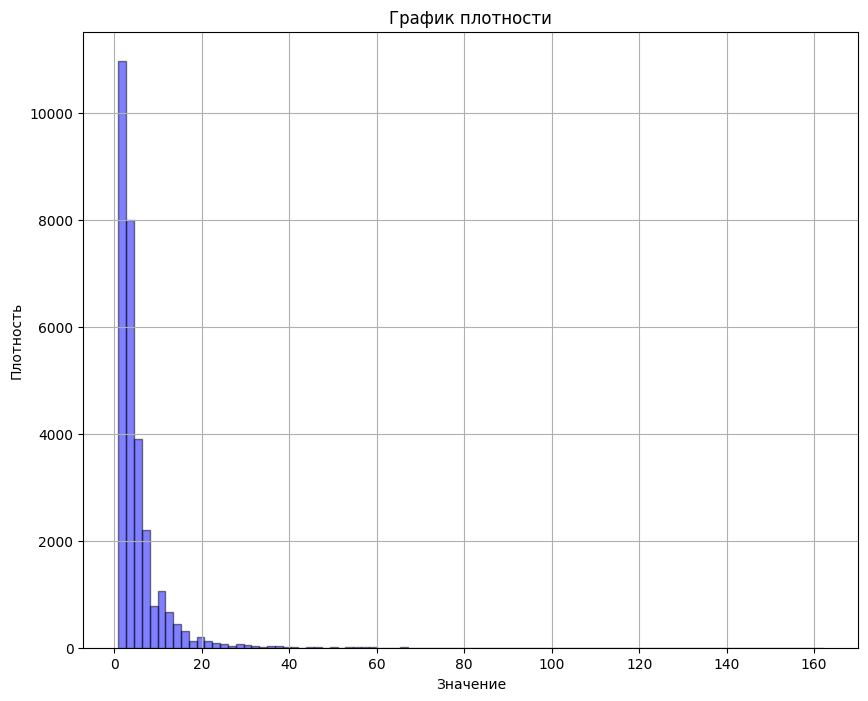

In [ ]:

plt.figure(figsize=(10, 8))
plt.hist(views_A, bins=90, density=False, alpha=0.5, color='blue', edgecolor='black')
plt.title('График плотности')
plt.xlabel('Значение')
plt.ylabel('Плотность')
plt.grid(True)
plt.show()

In [ ]:
df = pd.DataFrame({'X':clicks_A,'Y':views_A})
AB_simulation(df, 'corr_ttest')
#better quality

,power,empirical_power,mde,sample_size,left_real_level,right_real_level
0,0.8,0.966667,0.18,9337,0.939738,0.981795
1,0.8,0.956667,0.17,10408,0.927283,0.974504
2,0.8,0.930000,0.16,11684,0.895364,0.953763
3,0.8,0.910000,0.15,13218,0.872223,0.937410
4,0.8,0.920000,0.14,15086,0.883727,0.945653


In [ ]:
check_delta_method(df_control.sample(n=11742, replace = False),df_test.sample(n=11742, replace = False))

[0.9530516760023854,
 {'pe_metric_a': 0.022483766233766234,
  'var_metric_a': 1.7849962901703357e-06,
  'pe_metric_b': 0.019428478912005182,
  'var_metric_b': 1.5414089037748649e-06}]

<font color='red'>test-2459</font>

In [ ]:
s = clean_data_2459.groupby('visitor_id').agg({'source' : pd.Series.nunique})
s[s['source'] > 1]
#one user had more than one source

,source
visitor_id,
50755,2


In [ ]:
s = clean_data_2459.groupby('visitor_id').agg({'device_type' : pd.Series.nunique})
s[s['device_type'] > 1]
#several users used both a phone and a computer

,device_type
visitor_id,
17485,2
18029,2
19011,2
20531,2
27451,2
56096,2


In [ ]:
#number of users
amount = clean_data_2459.groupby(by = 'ab_test_version').agg({'visitor_id' : pd.Series.nunique})
amount = amount.rename(columns = {'visitor_id' : 'amount'})
amount

,amount
ab_test_version,
2459:control,27682
2459:test,27784


In [ ]:
#number of visits
visits = clean_data_2459.groupby(['ab_test_version', 'visitor_id']).agg({'visit_num' : pd.Series.nunique})\
.groupby('ab_test_version').agg({'visit_num' : sum})
visits = visits.rename(columns = {'visit_num' : 'visits'})
visits

,visits
ab_test_version,
2459:control,29109
2459:test,29257


In [ ]:
#number of users with submits
submit_visits = clean_data_2459[clean_data_2459['event_name'] == 'formSubmit'].groupby(['ab_test_version', 'visitor_id'])\
.agg({'visit_num' : pd.Series.nunique}).groupby('ab_test_version').agg({'visit_num' : sum})
submit_visits = submit_visits.rename(columns = {'visit_num' : 'submit_visits'})
submit_visits

,submit_visits
ab_test_version,
2459:control,639
2459:test,583


In [ ]:
res_AB = amount.join(visits.join(submit_visits))
res_AB
res_AB['CR'] = res_AB['submit_visits'] / res_AB['visits']
res_AB


,amount,visits,submit_visits
ab_test_version,,,
2459:control,27682,29109,639
2459:test,27784,29257,583


,amount,visits,submit_visits,CR
ab_test_version,,,,
2459:control,27682,29109,639,0.021952
2459:test,27784,29257,583,0.019927


In [ ]:
#amount of users for every source
amount_s = clean_data_2459.groupby(['source', 'ab_test_version']).agg({'visitor_id' : pd.Series.nunique})
amount_s = amount_s.rename(columns = {'visitor_id' : 'amount'})
amount_s

amount
source  ab_test_version        
source1 2459:control          1
        2459:test             1
source2 2459:control         16
        2459:test            28
source3 2459:control      27665
        2459:test         27756

In [ ]:
#amount of visits for every source
visits_s = clean_data_2459.groupby(['source', 'ab_test_version', 'visitor_id']).agg({'visit_num' : pd.Series.nunique})\
.groupby(['source', 'ab_test_version']).agg({'visit_num' : sum})
visits_s = visits_s.rename(columns = {'visit_num' : 'visits'})
visits_s

visits
source  ab_test_version        
source1 2459:control          2
        2459:test             1
source2 2459:control         20
        2459:test            32
source3 2459:control      29087
        2459:test         29224

In [ ]:
#amount of submits for every source
submit_visits_s = clean_data_2459[clean_data_2459['event_name'] == 'formSubmit'].groupby(['source', 'ab_test_version', 'visitor_id'])\
.agg({'visit_num' : pd.Series.nunique}).groupby(['source', 'ab_test_version']).agg({'visit_num' : sum})
submit_visits_s = submit_visits_s.rename(columns = {'visit_num' : 'submit_visits'})
submit_visits_s

submit_visits
source  ab_test_version               
source3 2459:control               639
        2459:test                  583

In [ ]:
res = amount_s.join(visits_s.join(submit_visits_s))

res = res.fillna(0)

res['CR'] = res['submit_visits'] / res['visits']
res

amount  visits  submit_visits        CR
source  ab_test_version                                         
source1 2459:control          1       2            0.0  0.000000
        2459:test             1       1            0.0  0.000000
source2 2459:control         16      20            0.0  0.000000
        2459:test            28      32            0.0  0.000000
source3 2459:control      27665   29087          639.0  0.021969
        2459:test         27756   29224          583.0  0.019949

In [ ]:
#the same as before but for device_type
amount_d = clean_data_2459.groupby(['device_type', 'ab_test_version']).agg({'visitor_id' : pd.Series.nunique})
amount_d = amount_d.rename(columns = {'visitor_id' : 'amount'})


visits_d = clean_data_2459.groupby(['device_type', 'ab_test_version', 'visitor_id']).agg({'visit_num' : pd.Series.nunique})\
.groupby(['device_type', 'ab_test_version']).agg({'visit_num' : sum})
visits_d = visits_d.rename(columns = {'visit_num' : 'visits'})


submit_visits_d = clean_data_2459[clean_data_2459['event_name'] == 'formSubmit'].groupby(['device_type', 'ab_test_version', 'visitor_id'])\
.agg({'visit_num' : pd.Series.nunique}).groupby(['device_type', 'ab_test_version']).agg({'visit_num' : sum})
submit_visits_d = submit_visits_d.rename(columns = {'visit_num' : 'submit_visits'})


res = amount_d.join(visits_d.join(submit_visits_d))


res['CR'] = res['submit_visits'] / res['visits']
res

amount  visits  submit_visits        CR
device_type ab_test_version                                         
Desktop     2459:control       4940    5208            100  0.019201
            2459:test          4778    4999             85  0.017003
Mobile      2459:control      22745   23901            539  0.022551
            2459:test         23009   24260            498  0.020528

In [ ]:
#for each user's visit, we find the date of the first action that took place in this session
first_date = clean_data_2459.groupby(['visitor_id', 'visit_num']).agg({'date' : min})
first_date = first_date.rename(columns = {'date' : 'first_date'})
first_date

first_date
visitor_id visit_num            
1          2          2021-01-12
2          13         2021-01-14
3          2          2021-01-14
5          2          2021-01-12
6          1          2021-01-12
...                          ...
75503      1          2021-01-11
75504      2          2021-01-11
           3          2021-01-12
75505      1          2021-01-11
75507      1          2021-01-14

[58366 rows x 1 columns]

In [ ]:
res = clean_data_2459.merge(first_date, on = ['visitor_id', 'visit_num'],how = 'left')
res

,hit_dttm,source,ab_test_version,device_type,visitor_id,visit_num,event_name,date,first_date
0,2021-01-11 10:20:00,source3,2459:control,Desktop,70905,1,pageview,2021-01-11,2021-01-11
1,2021-01-11 10:20:00,source3,2459:test,Mobile,66317,2,pageview,2021-01-11,2021-01-11
2,2021-01-11 10:20:00,source3,2459:control,Desktop,26680,1,pageview,2021-01-11,2021-01-11
3,2021-01-11 10:20:00,source3,2459:control,Mobile,24275,1,pageview,2021-01-11,2021-01-11
4,2021-01-11 10:20:00,source3,2459:control,Desktop,11085,1,pageview,2021-01-11,2021-01-11
...,...,...,...,...,...,...,...,...,...
64648,2021-01-14 23:37:00,source3,2459:test,Mobile,50468,2,pageview,2021-01-14,2021-01-14
64649,2021-01-14 23:40:00,source3,2459:control,Desktop,18797,4,pageview,2021-01-14,2021-01-14
64650,2021-01-14 23:42:00,source3,2459:control,Mobile,44382,1,pageview,2021-01-14,2021-01-14
64651,2021-01-14 23:46:00,source3,2459:test,Mobile,23312,1,pageview,2021-01-14,2021-01-14


In [ ]:
#next, I will consider the conversion by date as follows:
#the conversion from a visit to submit will relate to a certain date if the first action in this visit was done in exactly this date
visits = res.groupby(['first_date', 'ab_test_version', 'visitor_id']).agg({'visit_num' : pd.Series.nunique})\
.groupby(['first_date' , 'ab_test_version']).agg({'visit_num' : sum})
visits = visits.rename(columns = {'visit_num' : 'visits'})
visits

visits
first_date ab_test_version        
2021-01-11 2459:control      13082
           2459:test         13170
2021-01-12 2459:control       9953
           2459:test          9947
2021-01-13 2459:control       4290
           2459:test          4298
2021-01-14 2459:control       1784
           2459:test          1842

In [ ]:
submit_visits = res[res['event_name'] == 'formSubmit'].groupby(['first_date', 'ab_test_version', 'visitor_id'])\
.agg({'visit_num' : pd.Series.nunique}).groupby(['first_date', 'ab_test_version']).agg({'visit_num' : sum})
submit_visits = submit_visits.rename(columns = {'visit_num' : 'submit_visits'})
submit_visits

submit_visits
first_date ab_test_version               
2021-01-11 2459:control               301
           2459:test                  276
2021-01-12 2459:control               236
           2459:test                  207
2021-01-13 2459:control                83
           2459:test                   69
2021-01-14 2459:control                19
           2459:test                   31

CR          
ab_test_version 2459:control 2459:test
first_date                            
2021-01-11          0.023009  0.020957
2021-01-12          0.023711  0.020810
2021-01-13          0.019347  0.016054
2021-01-14          0.010650  0.016830

Text(0, 0.5, 'CR')

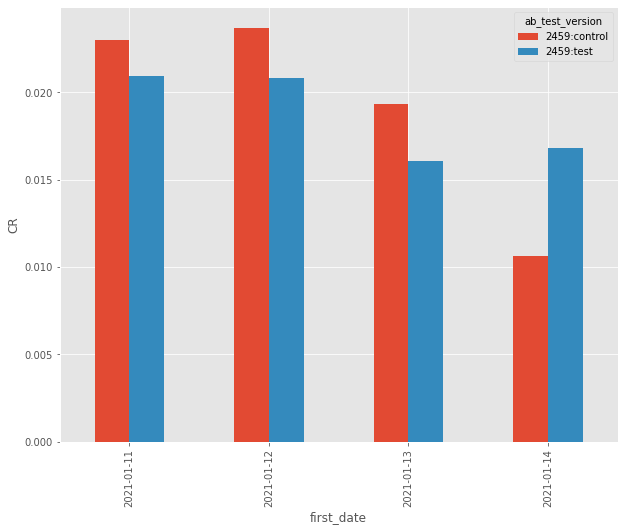

In [ ]:
#vizualization for conversion by dates
res = visits.join(submit_visits)
res['CR'] = res['submit_visits'] / res['visits']
res = res[['CR']].unstack()
res
res.plot(kind = 'bar',y = 'CR',figsize = (10,8), grid = True).set_ylabel('CR')

In [ ]:
res_AB

,amount,visits,submit_visits,CR
ab_test_version,,,,
2459:control,27682,29109,639,0.021952
2459:test,27784,29257,583,0.019927
